In [ ]:
# 挂载自己的Google 
! pip install google.colab
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import tabulate
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import pdb

## a. Questions: 
> What is the feature of interest? Describe in detail how you selected the images based on the feature of interest and on features of no interest.

> answer: the mouth curve

# Data pre-processing

### Load the data in your analysis environment of choice (Matlab, Python, ...)

**finish 3."Run the experiment" and 4.a**

In [4]:
# filename=r'/content/drive/Othercomputers/我的 MacBook Pro/Desktop/02458/results.txt'
# filename=r'/Users/baixiang/Desktop/02458/results.csv'
filename = '/Users/francis/Desktop/DTU/classes/02458/Stimulus presentation script/results.txt'
attributeNames = ['subject_id','trial_number','stimulus_filename','answer','reaction_time']
result = ['Not smiling','Smiling']
result_dits = [0, 1]
df = pd.read_csv(filename, names = attributeNames)
train_data = df.values
# show DataFrame data, only 5 head items and 5 tail items
display(df.head(5), df.tail(5))
# show Numpy data, only first 10 rows
display(HTML(tabulate.tabulate(train_data[:9], headers=attributeNames, showindex='always', tablefmt='html')))

,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,1,ARimage29.png,Smiling,2.5074
1,213,2,ARimage107.png,Not smiling,0.8390
2,213,3,ARimage146.png,Not smiling,0.6857
3,213,4,ARimage244.png,Smiling,0.7164
4,213,5,ARimage276.png,Not smiling,0.7076


,subject_id,trial_number,stimulus_filename,answer,reaction_time
889,213120,294,ARimage68.png,Smiling,0.7244
890,213120,295,ARimage200.png,Not smiling,0.8023
891,213120,296,ARimage103.png,Not smiling,0.5948
892,213120,297,ARimage172.png,Smiling,0.6943
893,213120,298,ARimage211.png,Smiling,0.6674


,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,1,ARimage29.png,Smiling,2.5074
1,213,2,ARimage107.png,Not smiling,0.839
2,213,3,ARimage146.png,Not smiling,0.6857
3,213,4,ARimage244.png,Smiling,0.7164
4,213,5,ARimage276.png,Not smiling,0.7076
5,213,6,ARimage97.png,Not smiling,0.6863
6,213,7,ARimage168.png,Not smiling,0.9747
7,213,8,ARimage270.png,Not smiling,0.8137
8,213,9,ARimage264.png,Not smiling,1.1978


### Consider removing outliers for the reaction time (above several seconds, below 200ms)

**finish 4.b**

There are two method:
1. if values > μ + 3σ and values < μ—3σ, I suppose they are outliers
2. if values > 1s and values < 200ms, I suppose they are outliers (from the project instruction)

I choose the second one, cause it's seems really efficient

In [6]:
mean = train_data[:,4].mean()                   # caluate the mean of the data we collected
std  = train_data[:,4].std()                    # caluate the Standard deviation of the data we collected

# 看有多少个测试者
observer_ID = sorted(set(train_data[:,0]))      # abstract the observer's ID
# observer_ID = np.unique(train_data[:,0])
print("observer_ID",observer_ID)

N = len(observer_ID)                            # count the amount of observer involved in our experiment

# show them all
print('There are', N, 'observers in the train dataset')
print('And they are', observer_ID)
print('The average reaction time of all the observers is', mean, 's, and the variance is', std)

# define the outlier threshod
upper_threshod, lower_threshod = 1, 0.2

'''clean the data, weed out outliers'''
X = []  # empty list to save the cleaned data

# counter of outliers
outliter = 0
for i in range(len(train_data[:,0])):
  if  lower_threshod < train_data[i,4] < upper_threshod:
    X.append(train_data[i])
  else:
    outliter += 1
print('There are', outliter, 'outliers in our data')

# '''show fist 10 rows of cleaned data X'''
display(HTML(tabulate.tabulate(X[:9], headers=attributeNames, showindex='always', tablefmt='html')))


observer_ID [213, 623, 213120]
There are 3 observers in the train dataset
And they are [213, 623, 213120]
The average reaction time of all the observers is 0.9465923937360174 s, and the variance is 0.9675626557172228
There are 197 outliers in our data


,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,2,ARimage107.png,Not smiling,0.839
1,213,3,ARimage146.png,Not smiling,0.6857
2,213,4,ARimage244.png,Smiling,0.7164
3,213,5,ARimage276.png,Not smiling,0.7076
4,213,6,ARimage97.png,Not smiling,0.6863
5,213,7,ARimage168.png,Not smiling,0.9747
6,213,8,ARimage270.png,Not smiling,0.8137
7,213,10,ARimage92.png,Smiling,0.6519
8,213,11,ARimage36.png,Not smiling,0.7939


**part of 4.c**

In [7]:
'''coding the face emotion results smelling and not smelling to digits'''
X = np.array(X)
for i in range(len(X[:,0])):
  if X[i,3] == 'Smiling':
    X[i,3] = 1
  else:
    X[i,3] = 0

# '''show fist 10 rows of cleaned data X'''
display(HTML(tabulate.tabulate(X[:9], headers=attributeNames, showindex='always', tablefmt='html')))

,subject_id,trial_number,stimulus_filename,answer,reaction_time
0,213,2,ARimage107.png,0,0.839
1,213,3,ARimage146.png,0,0.6857
2,213,4,ARimage244.png,1,0.7164
3,213,5,ARimage276.png,0,0.7076
4,213,6,ARimage97.png,0,0.6863
5,213,7,ARimage168.png,0,0.9747
6,213,8,ARimage270.png,0,0.8137
7,213,10,ARimage92.png,1,0.6519
8,213,11,ARimage36.png,0,0.7939


### Normalise the reaction times for each person and then pool them into one data set.
**finish 4.c**
There are many kinds of normalise methods:
1. z = (x - u) / s
2. z = (x - u)

In [8]:
plt.rcParams['figure.dpi'] = 200  # setting the 
# names = locals()
names = {}
for i in range(N):
  names['observer' + str(i)] = []


for j in range(len(X[:,0])):
  for i in range(N):
    # Zhijian Feng 21.30.21.05
    # if X[j,0] == observor_ID[i]:
    if X[j,0] == observer_ID[i]:
      names['observer' + str(i)].append(X[j])

# convert the list to numpy array and Normalization
for i in range(N):
  names['observer' + str(i)] = np.array(names['observer' + str(i)])
  tmp_mean = names['observer' + str(i)][:,4].mean()
  tmp_std = names['observer' + str(i)][:,4].std()
  temp_normal = ((names['observer' + str(i)][:,4]- tmp_mean) / tmp_std)
  temp_normal = np.reshape(temp_normal,(len(temp_normal),1))
  names['observer' + str(i)] = np.hstack((names['observer' + str(i)],temp_normal))

# print(names['observer0'][:,1])
# 现在整个数据结构就是，names这个dict用来存所有的数据，里面用 “observer$num.format(test_number,%d)" 来索引每一个用户。
# 然后里面每一个observer里面的结构是一个二维数组，保持原来的特性 
# 二维数组的属性：subject_id, trial_number, stimulus_filename, answer, reaction_time, normal_value


# for i in range(N):
#   # names['observer' + str(i)] = np.array(names['observer' + str(i)])
#   # observer_mean = names['observer' + str(i)][:,4].mean()
#   # observer_std = names['observer' + str(i)][:,4].std()
#   # names['observer' + str(i) + '_normal'] = ((names['observer' + str(i)][:,4]- observer_mean) / observer_std).flatten()
#   # print(names['observer' + str(i) + '_normal'].shape)
#   # print(names['observer' + str(i) + '_normal'].flatten())
#   plt.subplot(1, N, i+1)
#   plt.hist(names['observer' + str(i)][:,5], bins=20)
#   # plt.title('observer' + str(i) + '[' + str(observer_ID[i]) + ']')
#   plt.title('observer' + str(i))
#   plt.xlabel('ReactTimeSpan')
#   plt.ylabel('Distribution')
#   plt.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)


**finish 5.a**

In [9]:
import cv2
import os
import pdb

image_path = r'/Users/francis/Desktop/DTU/classes/02458/ARArchive/'

all_image_values = np.zeros((50,50),dtype=np.uint16)
# all_image_values = cv2.cvtColor(all_image_values, cv2.COLOR_GRAY2BGR)

ori_imgs = []
for f_name in os.listdir(image_path):

    if f_name == ".DS_Store":
        continue

    tmp_path = os.path.join(image_path,f_name)
    img = cv2.imread(tmp_path,-1)
    ori_imgs.append(img)
    for i in range(3):
        all_image_values[:,:] = all_image_values[:,:] + img[:,:]

ori_imgs = np.array(ori_imgs)
mean_value = all_image_values / (len(os.listdir(image_path))-1)

for i in range(len(ori_imgs)):
    ori_imgs[i] = ori_imgs[i] - mean_value

print(ori_imgs.shape)



(298, 50, 50)


**finish5.b**

V.shape (2500, 298)
sequence_imgs.shape (298, 2500)
Z.shape (298,)
(298,)


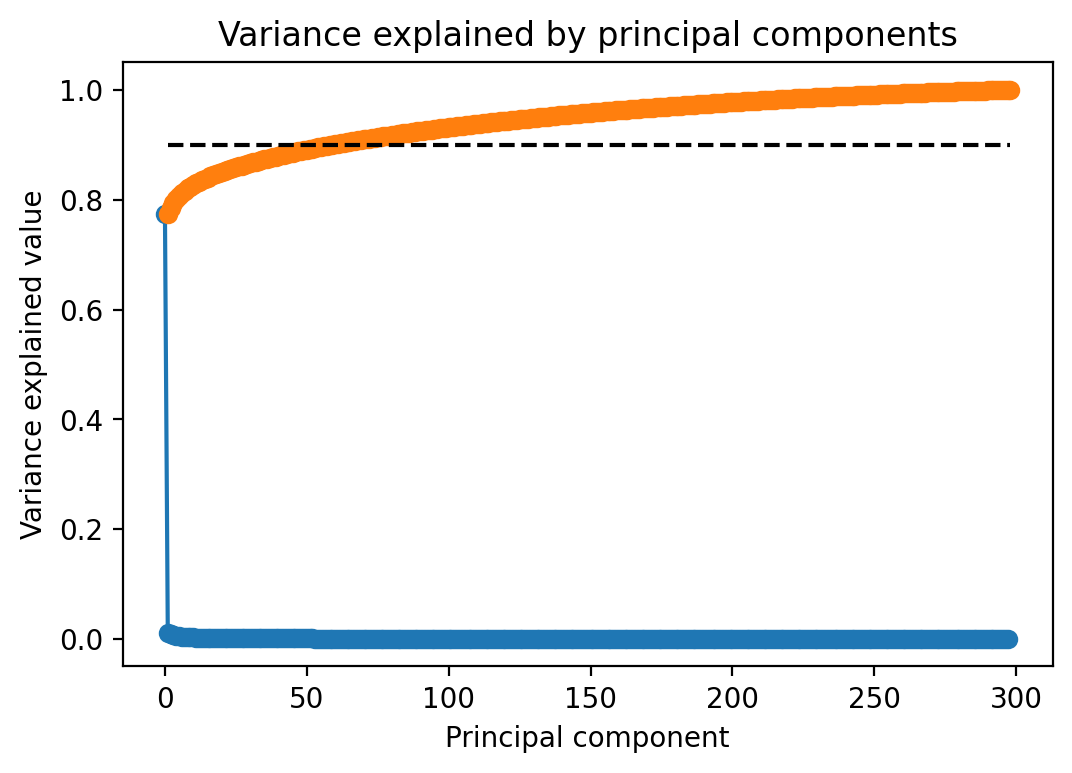

In [15]:
import scipy
import scipy.linalg as linalg
import matplotlib.pyplot as plt


# Obtain the PCA solution  by calculate the SVD of Y

# sequence
sequence_imgs = []
for i in range(len(ori_imgs)):
    sequence_imgs.append(ori_imgs[i].reshape(1,50*50))

sequence_imgs = np.array(sequence_imgs)
d_1,d_2,d_3 = sequence_imgs.shape
sequence_imgs = np.reshape(sequence_imgs,(d_1,d_3))

# print(ssequence_imgs.shape)

U,S,V = linalg.svd(sequence_imgs,full_matrices=False)
V = V.T
# Compute variance explained by principal components
rho = (S*S) / (S*S).sum() 

# plt.show(np.reshape(sequence_imgs[0]),(50,50))
# print(sequence_imgs[0].shape)
# cv2.imshow("11",V0)
# cv2.waitKey(1)
# Project data onto principal component space
Z = sequence_imgs @ V[:,50] 
print("V.shape",V.shape)
print("sequence_imgs.shape",sequence_imgs.shape)
print("Z.shape",Z.shape)

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1,len(rho)+1),rho,'x-')                  # 绘制各在成分上投影的方差
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')       # 绘制各成分累加的可解释变异或课解释方差
plt.plot([1,len(rho)],[threshold, threshold],'k--')     # 绘制压缩要求阈值
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.show()

print(Z.shape)


# # Plot PCA of the data
# f = plt.figure()
# plt.title('pixel vectors of handwr. digits projected on PCs')
# n = [0,1,2,3]
# for c in n:
#     # select indices belonging to class c:
#     class_mask = (y == c)
#     plt.plot(Z[class_mask,0], Z[class_mask,1], 'o')
# plt.legend("classNames")
# plt.xlabel('PC1')
# plt.ylabel('PC2')


KeyError: 'observer0_normal'

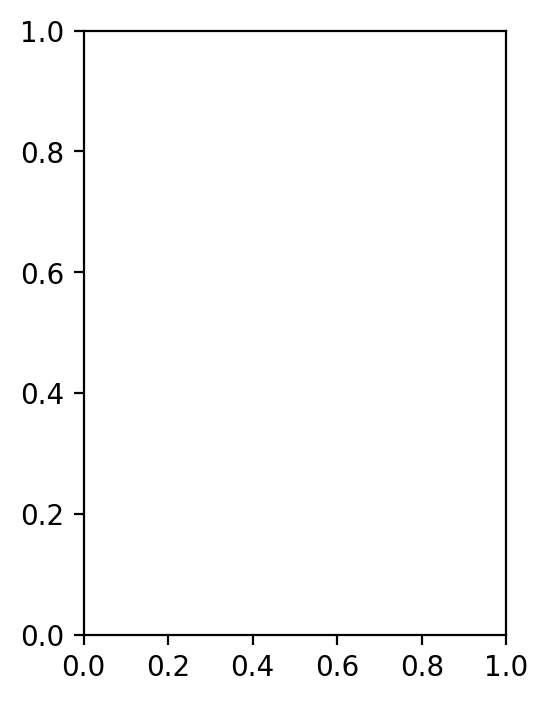

In [12]:
for c in result_dits:
  plt.subplot(1, 2, c+1)
  for i in range(N):
    # select indices belonging to class c:
    class_mask = names['observer' + str(i)][:,3]==c # range(len(names['observer' + str(i)][class_mask,0]))
    plt.plot([i+1 for j in names['observer' + str(i) + '_normal'][class_mask]], names['observer' + str(i) + '_normal'][class_mask], 'o', alpha=.3)
  plt.legend(['observer' + str(j) + '[' + str(observor_ID[j]) + ']' for j in range(N)], frameon=False, loc='lower center')
  plt.title(result[c])
  plt.ylabel('React Time')
  plt.xlabel('Observer')
  plt.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)
